# New approach to GPs to improve performance

In [1]:
from scipy import stats, special, math
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import pymc3 as pm
import arviz as az
import pandas as pd
from theano import shared
from theano import tensor as T
import seaborn as sns
from scipy.special import expit as logistic
import statsmodels as sm
from statsmodels.graphics import tsaplots as smplots
import warnings
import theano
import theano.tensor as tt
from scipy.special import expit as logistic
import seaborn as sns

import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import statsmodels as stm

az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

In [167]:
prison = pd.read_csv('./data/prisonLF.csv', sep=",")
prison = prison.drop('Unnamed: 0', axis =1)
prison['t'] = prison['t'].astype('datetime64[ns]')

In [303]:
prison_pivot = prison.pivot(index='t',columns=['state', 'gender', 'legal'], values='count')

# Forecast horizon
h = 8
y_train = prison_pivot.iloc[:-8,:]
y = prison_pivot

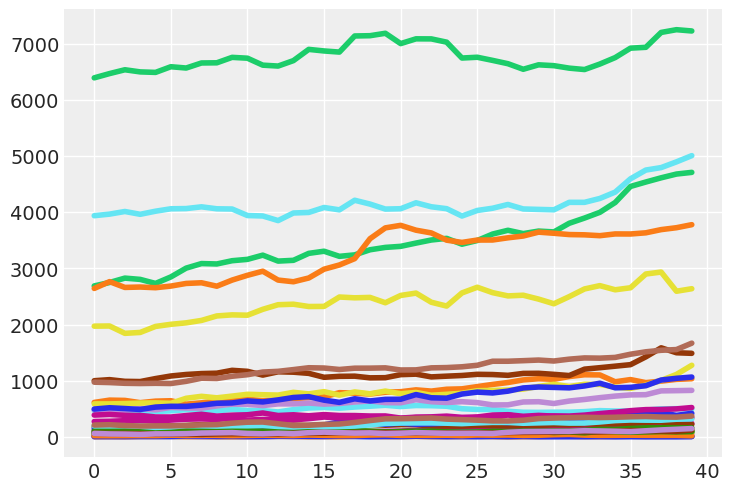

In [304]:
def generate_groups_info(y):
    
    n=y.shape[0]
    s=y.shape[1]
    n_series = y.columns.unique().shape[0]
    
    state_idx_list = pd.get_dummies(
        [i[0] for i in y]
    ).values.argmax(1)

    gender_idx_list = pd.get_dummies(
            [i[1] for i in y]
        ).values.argmax(1)

    legal_idx_list = pd.get_dummies(
            [i[2] for i in y]
        ).values.argmax(1)

    state = np.unique(state_idx_list).shape[0]
    gender = np.unique(gender_idx_list).shape[0]
    legal = np.unique(legal_idx_list).shape[0]
    
    state_idx = pd.get_dummies(
            [i[0] for i in y]
        ).values.argmax(1)
    state_idx = np.tile(state_idx, (n,1)).flatten('F')
    gender_idx = pd.get_dummies(
            [i[1] for i in y]
        ).values.argmax(1)
    gender_idx = np.tile(gender_idx, (n,1)).flatten('F')

    legal_idx = pd.get_dummies(
            [i[2] for i in y]
        ).values.argmax(1)
    legal_idx = np.tile(legal_idx, (n,1)).flatten('F')

    state = np.unique(state_idx).shape[0]
    gender = np.unique(gender_idx).shape[0]
    legal = np.unique(legal_idx).shape[0]

    n_series_idx = np.tile(np.arange(s), (n,1)).flatten('F')
    n_series_idx_list = np.arange(s)

    state_idx_list = pd.get_dummies(
            [i[0] for i in y]
        ).values.argmax(1)

    gender_idx_list = pd.get_dummies(
            [i[1] for i in y]
        ).values.argmax(1)

    legal_idx_list = pd.get_dummies(
            [i[2] for i in y]
        ).values.argmax(1)

    state = np.unique(state_idx_list).shape[0]
    gender = np.unique(gender_idx_list).shape[0]
    legal = np.unique(legal_idx_list).shape[0]

    return (state_idx, 
            gender_idx,
            legal_idx,
            n_series_idx,
            state,
            gender,
            legal,
            n,
            s,
            n_series)

(state_idx, 
 gender_idx, 
 legal_idx,
 n_series_idx, 
 state, 
 gender,
 legal,
 n,
 s,
 n_series) = generate_groups_info(y_train)


y_train = y_train.values
y_ = y_train
X = np.arange(y_train.shape[0]).reshape(y_train.shape[0], 1)
plt.plot(x, y_train);

y_ = y_.T.ravel()

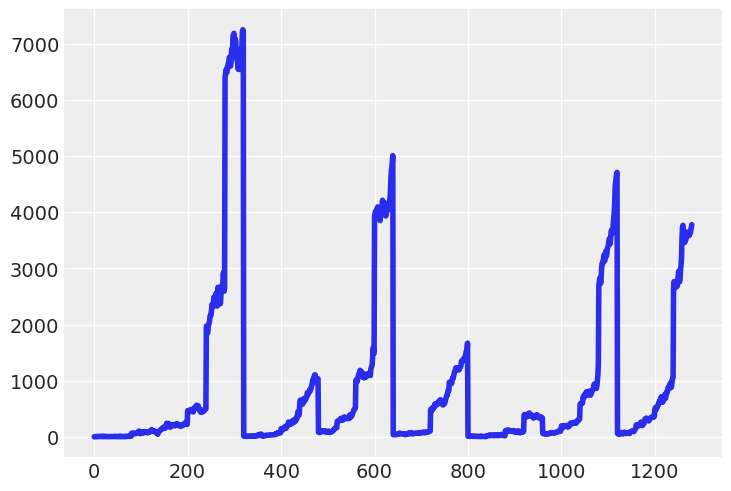

In [305]:
plt.plot(y_);

We will define a more compact covariance matrices to model latent behaviours of each element of each group. We only need them to be UxU where U is the unique number of inputs for the given GP. All the GPs will therefore have a covariance matrix that depend on number of time points and it would be txt, where t is the number of periods observed in the data. In our case it is 48. The Poisson likelihood needs to be computed for the N data points (all time series).

In [306]:
fem_idx = (gender_idx +1)%2
mal_idx = gender_idx
rem_idx = (legal_idx +1)%2
sen_idx = legal_idx
nsw_idx = np.where(state_idx==0,1,0)
wa_idx = np.where(state_idx==2,1,0)
sa_idx = np.where(state_idx==1,1,0)

In [307]:
with pm.Model() as model_h_cox_gp_cor:
    
    # Hyper-parameter priors
    
    period = pm.Laplace('period', 4, 0.1)
    
    
    l_t_fem = pm.Gamma('l_t_fem', alpha=5, beta=1)
    l_p_fem = pm.Gamma('l_p_fem', alpha=5, beta=1)
    η_trend_fem = pm.HalfNormal('η_trend_fem', 5)
    η_per_fem = pm.HalfNormal('η_per_fem',5)
    σ_fem  = pm.HalfNormal("σ_fem",  sigma=0.1)
    
    l_t_mal = pm.Gamma('l_t_mal', alpha=5, beta=1)
    l_p_mal = pm.Gamma('l_p_mal', alpha=5, beta=1)
    η_trend_mal = pm.HalfNormal('η_trend_mal', 5)
    η_per_mal = pm.HalfNormal('η_per_mal',5)
    σ_mal  = pm.HalfNormal("σ_mal",  sigma=0.1)
    
    l_t_sen = pm.Gamma('l_t_sen', alpha=5, beta=1)
    l_p_sen = pm.Gamma('l_p_sen', alpha=5, beta=1)
    η_trend_sen = pm.HalfNormal('η_trend_sen', 5)
    η_per_sen = pm.HalfNormal('η_per_sen',5)
    σ_sen  = pm.HalfNormal("σ_sen",  sigma=0.1)
    
    l_t_rem = pm.Gamma('l_t_rem', alpha=5, beta=1)
    l_p_rem = pm.Gamma('l_p_rem', alpha=5, beta=1)
    η_trend_rem = pm.HalfNormal('η_trend_rem', 5)
    η_per_rem = pm.HalfNormal('η_per_rem',5)
    σ_rem  = pm.HalfNormal("σ_rem",  sigma=0.1)
    
    l_t_nsw = pm.Gamma('l_t_nsw', alpha=5, beta=1)
    l_p_nsw = pm.Gamma('l_p_nsw', alpha=5, beta=1)
    η_trend_nsw = pm.HalfNormal('η_trend_nsw', 5)
    η_per_nsw = pm.HalfNormal('η_per_nsw',5)
    σ_nsw  = pm.HalfNormal("σ_nsw",  sigma=0.1)
    
    l_t_wa = pm.Gamma('l_t_wa', alpha=5, beta=1)
    l_p_wa = pm.Gamma('l_p_wa', alpha=5, beta=1)
    η_trend_wa = pm.HalfNormal('η_trend_wa', 5)
    η_per_wa = pm.HalfNormal('η_per_wa',5)
    σ_wa  = pm.HalfNormal("σ_wa",  sigma=0.1)
    
    l_t_sa = pm.Gamma('l_t_sa', alpha=5, beta=1)
    l_p_sa = pm.Gamma('l_p_sa', alpha=5, beta=1)
    η_trend_sa = pm.HalfNormal('η_trend_sa', 5)
    η_per_sa = pm.HalfNormal('η_per_sa',5)
    σ_sa  = pm.HalfNormal("σ_sa",  sigma=0.1)
    
    # Cov func for the overall GP
    cov_fem = (η_trend_fem**2 * pm.gp.cov.Matern32(input_dim=1, ls=l_t_fem)
                + η_per_fem**2 * pm.gp.cov.Periodic(1, period=period, ls=l_p_fem) 
                + pm.gp.cov.WhiteNoise(σ_fem))
    cov_mal = (η_trend_mal**2 * pm.gp.cov.Matern32(input_dim=1, ls=l_t_mal)
                + η_per_mal**2 * pm.gp.cov.Periodic(1, period=period, ls=l_p_mal) 
                + pm.gp.cov.WhiteNoise(σ_mal))
    cov_sen = (η_trend_sen**2 * pm.gp.cov.Matern32(input_dim=1, ls=l_t_sen)
            + η_per_sen**2 * pm.gp.cov.Periodic(1, period=period, ls=l_p_sen) 
            + pm.gp.cov.WhiteNoise(σ_sen))
    cov_rem = (η_trend_rem**2 * pm.gp.cov.Matern32(input_dim=1, ls=l_t_rem)
        + η_per_rem**2 * pm.gp.cov.Periodic(1, period=period, ls=l_p_rem) 
        + pm.gp.cov.WhiteNoise(σ_rem))
    
    cov_nsw = (η_trend_nsw**2 * pm.gp.cov.Matern32(input_dim=1, ls=l_t_nsw)
                + η_per_nsw**2 * pm.gp.cov.Periodic(1, period=period, ls=l_p_nsw) 
                + pm.gp.cov.WhiteNoise(σ_nsw))
    cov_wa = (η_trend_wa**2 * pm.gp.cov.Matern32(input_dim=1, ls=l_t_wa)
            + η_per_wa**2 * pm.gp.cov.Periodic(1, period=period, ls=l_p_wa) 
            + pm.gp.cov.WhiteNoise(σ_wa))
    cov_sa = (η_trend_sa**2 * pm.gp.cov.Matern32(input_dim=1, ls=l_t_sa)
        + η_per_sa**2 * pm.gp.cov.Periodic(1, period=period, ls=l_p_sa) 
        + pm.gp.cov.WhiteNoise(σ_sa))
    
    
    hy_a0_mu = pm.Normal('hy_a0_mu', mu=0.0, sd=10)
    
    a0 = pm.Normal('a0', mu=hy_a0_mu, sd=2, shape=n_series)      
    a_fem = pm.Normal('a_fem', mu=0, sd=2)
    a_mal = pm.Normal('a_mal', mu=0, sd=2)
    b_fem = pm.Normal('b_fem', mu=0, sd=0.5)
    b_mal = pm.Normal('b_mal', mu=0, sd=0.5)
    a_sen = pm.Normal('a_sen', mu=0, sd=2)
    a_rem = pm.Normal('a_rem', mu=0, sd=2)
    b_sen = pm.Normal('b_sen', mu=0, sd=0.5)
    b_rem = pm.Normal('b_rem', mu=0, sd=0.5)
    a_nsw = pm.Normal('a_nsw', mu=0, sd=2)
    a_wa = pm.Normal('a_wa', mu=0, sd=2)
    a_sa = pm.Normal('a_sa', mu=0, sd=2)
    b_nsw = pm.Normal('b_nsw', mu=0, sd=0.5)
    b_wa = pm.Normal('b_wa', mu=0, sd=0.5)
    b_sa = pm.Normal('b_sa', mu=0, sd=0.5)
       
    
    mu_func_fem = pm.gp.mean.Linear(intercept = a_fem,
                         coeffs = b_fem)
    mu_func_mal = pm.gp.mean.Linear(intercept = a_mal,
                         coeffs = b_mal)
    mu_func_sen = pm.gp.mean.Linear(intercept = a_sen,
                         coeffs = b_sen)
    mu_func_rem = pm.gp.mean.Linear(intercept = a_rem,
                         coeffs = b_rem)
    mu_func_nsw = pm.gp.mean.Linear(intercept = a_nsw,
                         coeffs = b_nsw)
    mu_func_wa = pm.gp.mean.Linear(intercept = a_wa,
                         coeffs = b_wa)
    mu_func_sa = pm.gp.mean.Linear(intercept = a_sa,
                         coeffs = b_sa)

    # Latent Gaussian Processes
    gp_fem = pm.gp.Latent(mean_func=mu_func_fem, cov_func=cov_fem)
    f_fem = gp_fem.prior('f_fem', X=X, reparameterize=True)
    gp_mal = pm.gp.Latent(mean_func=mu_func_mal, cov_func=cov_mal)
    f_mal = gp_mal.prior('f_mal', X=X, reparameterize=True)
    gp_sen = pm.gp.Latent(mean_func=mu_func_sen, cov_func=cov_sen)
    f_sen = gp_sen.prior('f_sen', X=X, reparameterize=True)
    gp_rem = pm.gp.Latent(mean_func=mu_func_rem, cov_func=cov_rem)
    f_rem = gp_rem.prior('f_rem', X=X, reparameterize=True)
    gp_nsw = pm.gp.Latent(mean_func=mu_func_nsw, cov_func=cov_nsw)
    f_nsw = gp_nsw.prior('f_nsw', X=X, reparameterize=True)
    gp_wa = pm.gp.Latent(mean_func=mu_func_wa, cov_func=cov_wa)
    f_wa = gp_wa.prior('f_wa', X=X, reparameterize=True)
    gp_sa = pm.gp.Latent(mean_func=mu_func_sa, cov_func=cov_sa)
    f_sa = gp_sa.prior('f_sa', X=X, reparameterize=True)
    
    f = (tt.tile(f_fem, (s,)) * fem_idx 
         + tt.tile(f_mal, (s,)) * mal_idx 
         + tt.tile(f_sen, (s,)) * sen_idx 
         + tt.tile(f_rem, (s,)) * rem_idx
         + tt.tile(f_nsw, (s,)) * nsw_idx
         + tt.tile(f_wa, (s,)) * wa_idx
         + tt.tile(f_sa, (s,)) * sa_idx
        )
        
    
    y_pred = pm.Poisson('y_pred', mu=tt.exp(f + a0[n_series_idx]), observed=y_)

In [308]:
with model_h_cox_gp_cor:
    mp = pm.find_MAP()

In [309]:
mp_list = [{key: mp.get(key) for key in [i for i in mp if not any(j in i for j in ['log', 'f_rotated_', 'rotated'])]}]

In [310]:
mp_list

[{'period': array(3.99982678),
  'hy_a0_mu': array(0.00122009),
  'a0': array([ 0.24158766, -0.47628831,  0.27795659, -0.15305103,  0.12270818,
         -0.05659224, -0.01873351,  0.01419185, -0.01656065, -0.24560867,
          0.00429846,  0.20677565,  0.79320236,  1.01841078,  0.64329725,
          0.92085192,  0.12657914, -0.54337606,  0.01361084, -0.29314011,
         -1.68790836, -1.54230803, -1.8289525 , -1.49986624,  0.44154266,
          0.58972665,  0.28122928,  0.74394051,  0.50684348,  0.78580878,
          0.18753413,  0.67503716]),
  'a_fem': array(0.05772148),
  'a_mal': array(0.17493435),
  'b_fem': array(0.02611471),
  'b_mal': array(0.03985692),
  'a_sen': array(0.14446673),
  'a_rem': array(0.08818909),
  'b_sen': array(0.0324933),
  'b_rem': array(0.03347832),
  'a_nsw': array(-0.10980657),
  'a_wa': array(-0.05110668),
  'a_sa': array(0.0615628),
  'b_nsw': array(-0.02470804),
  'b_wa': array(-0.00415767),
  'b_sa': array(0.0102903),
  'l_t_fem': array(4.73819875),


In [311]:
with model_h_cox_gp_cor:
    pred_samples = pm.sample_posterior_predictive([mp], 
                                                  vars=[y_pred], 
                                                  samples=500)

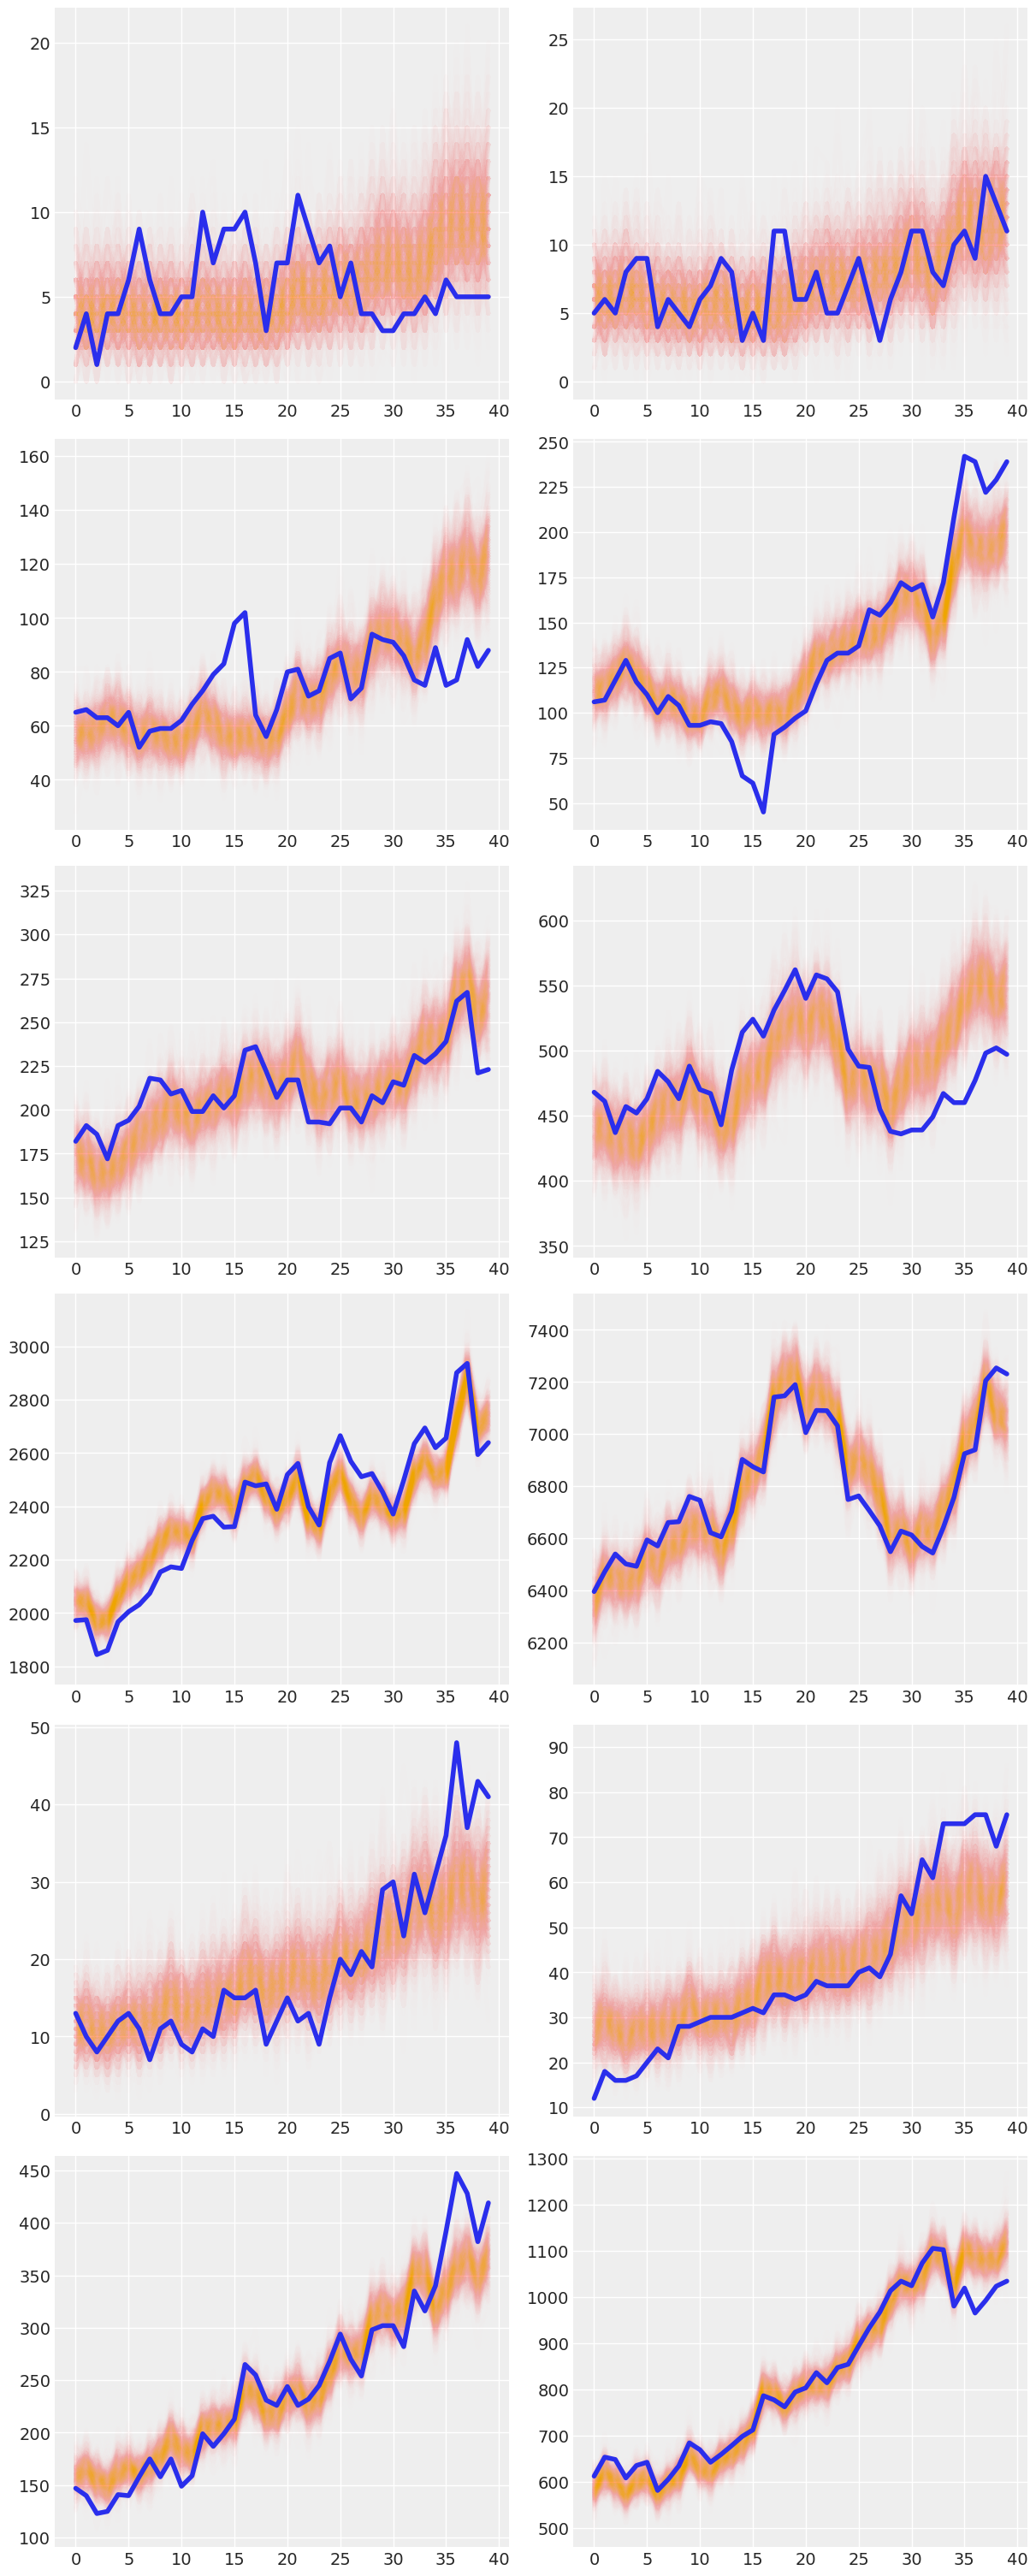

In [312]:
fig, ax = plt.subplots(6, 2, figsize=(12,30))
ax = np.ravel(ax)
for i in range(12):
    ax[i].plot(np.arange(n), pred_samples['y_pred'].T[i*n:i*n+n,:], alpha=0.003, color='orange')
    ax[i].plot(y_train[:,i]);

In [313]:
n_new = n+h
X_new = np.arange(n_new).reshape(-1,1)

In [314]:
with model_h_cox_gp_cor:
    f_n0_fem = gp_fem.conditional('f_n0_fem', Xnew=X_new)
    f_n0_rem = gp_rem.conditional('f_n0_rem', Xnew=X_new)
    f_n0_nsw = gp_nsw.conditional('f_n0_nsw', Xnew=X_new)

In [322]:
with model_h_cox_gp_cor:
    f_n0_mal = gp_mal.conditional('f_n0_mal', Xnew=X_new)
    f_n0_sen = gp_sen.conditional('f_n0_sen', Xnew=X_new)

In [332]:
n_series_idx[7*n]

7

In [334]:
with model_h_cox_gp_cor:

    f_ = f_n0_mal + f_n0_sen + f_n0_nsw
    
    y_pred_new_7 = pm.Poisson("y_pred_new_7", 
                            mu=pm.math.exp(f_ + a0[n_series_idx[7*n]]), 
                            shape=X_new.shape[0])

In [338]:
with model_h_cox_gp_cor:
    pred_samples0 = pm.sample_posterior_predictive([mp], 
                                                  vars=[y_pred_new_7], 
                                                  samples=100)

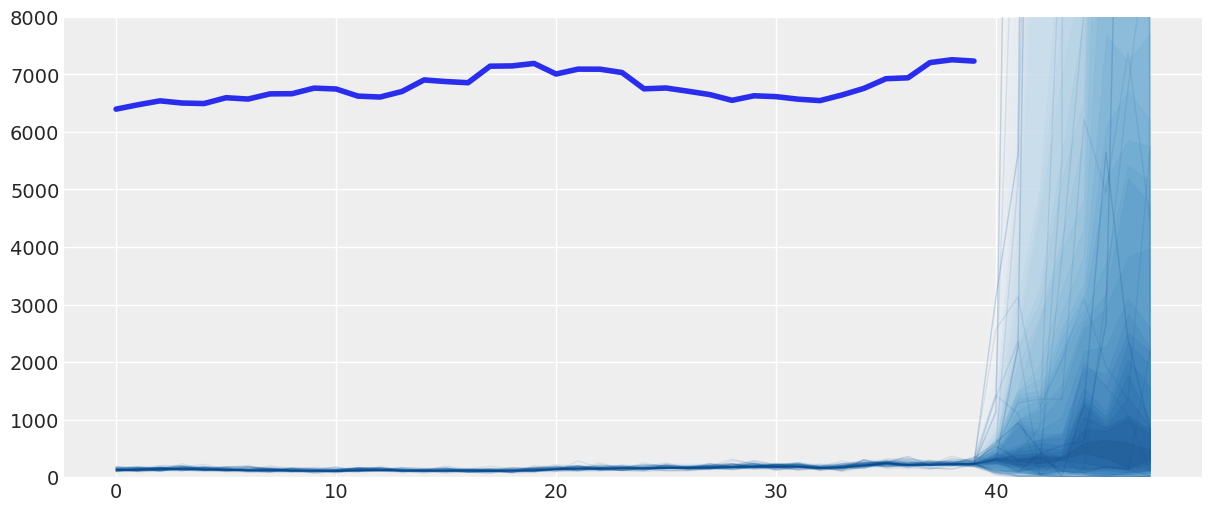

In [339]:
from pymc3.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, pred_samples0['y_pred_new_7'], X_new, palette="Blues", fill_alpha=0.1, samples_alpha=0.1);
plt.plot(np.arange(n),y_train[:,7])
plt.ylim(0,8000);

In [260]:
(state_idx, 
 gender_idx, 
 legal_idx,
 n_series_idx, 
 state, 
 gender,
 legal,
 n,
 s,
 n_series) = generate_groups_info(y)

fem_idx = (gender_idx +1)%2
mal_idx = gender_idx
rem_idx = (legal_idx +1)%2
sen_idx = legal_idx
nsw_idx = np.where(state_idx==0,1,0)
wa_idx = np.where(state_idx==2,1,0)
sa_idx = np.where(state_idx==1,1,0)

In [261]:
# Generate forecasts for all series
y_pred_new=[]
with model_h_cox_gp_cor:
    f_pred_fem = gp_fem.conditional('f_pred_fem', Xnew=X_new)
    f_pred_mal = gp_fem.conditional('f_pred_mal', Xnew=X_new)
    f_pred_sen = gp_rem.conditional('f_pred_sen', Xnew=X_new)
    f_pred_rem = gp_rem.conditional('f_pred_rem', Xnew=X_new)
    f_pred_nsw = gp_nsw.conditional('f_pred_nsw', Xnew=X_new)
    f_pred_wa = gp_nsw.conditional('f_pred_wa', Xnew=X_new)
    f_pred_sa = gp_nsw.conditional('f_pred_sa', Xnew=X_new)
    
    f_pred = (tt.tile(f_pred_fem, (s,)) * fem_idx 
         + tt.tile(f_pred_mal, (s,)) * mal_idx 
         + tt.tile(f_pred_sen, (s,)) * sen_idx 
         + tt.tile(f_pred_rem, (s,)) * rem_idx
         + tt.tile(f_pred_nsw, (s,)) * nsw_idx
         + tt.tile(f_pred_wa, (s,)) * wa_idx
         + tt.tile(f_pred_sa, (s,)) * sa_idx
        )
    
    y_pred_new = pm.Poisson("y_pred_new", 
                            mu=pm.math.exp(f_pred + a0[n_series_idx]), 
                            shape=n*s)

In [263]:
with model_h_cox_gp_cor:
    pred_samples = pm.sample_posterior_predictive([mp], 
                                                  vars=[y_pred_new],
                                                  samples=100)

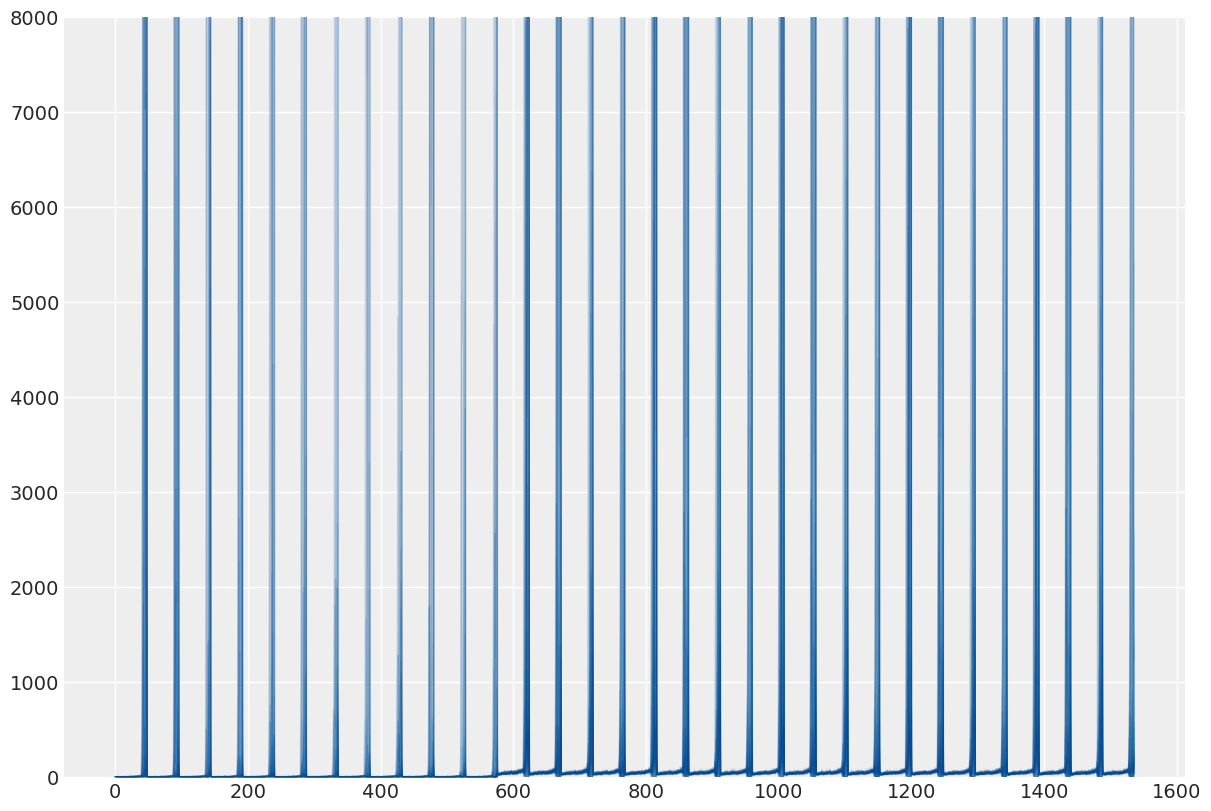

In [302]:
fig, ax = plt.subplots(figsize=(12,8))
ax = np.ravel(ax)
ax = fig.gca()

plot_gp_dist(ax, pred_samples['y_pred_new'], np.arange(n*s), palette="Blues", fill_alpha=0.1, samples_alpha=0.1);
#plt.plot(np.arange(n),y[:,0])
plt.ylim(0,8000);